In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021654A95F98>,
      dtype=object)

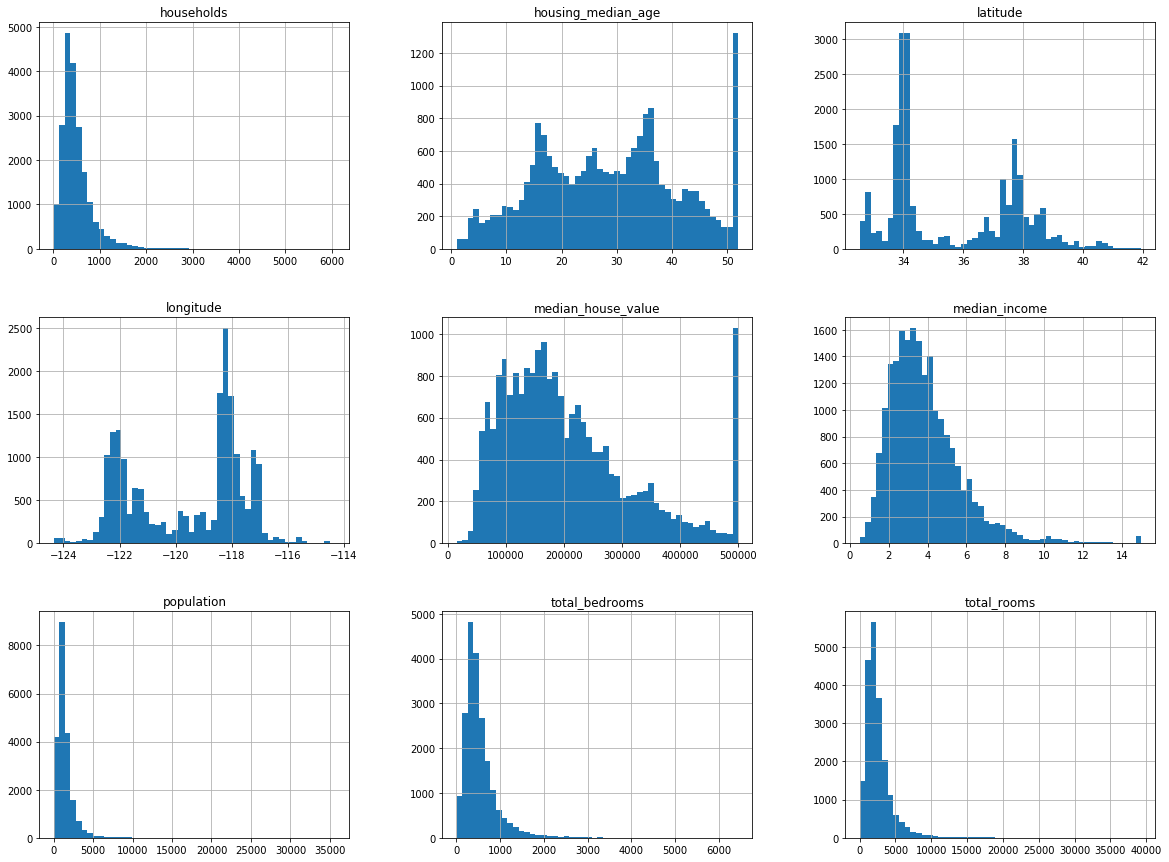

In [7]:
import matplotlib.pyplot as plt

housing.hist(bins = 50,figsize=(20,15))

In [8]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
housing_with_id = housing.reset_index()
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    #print("ids ",ids)
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    print(in_test_set)
    return data.loc[~in_test_set], data.loc[in_test_set]
t_set,te_set = split_train_test_by_id(housing_with_id,0.2,"index")

0        False
1        False
2         True
3        False
4        False
         ...  
20635    False
20636    False
20637    False
20638    False
20639    False
Name: index, Length: 20640, dtype: bool


In [11]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index,test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [13]:
#strat_test_set.drop("income_cat",axis =1, inplace= True)
strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,5
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,4
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,3
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND,3
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND,3


In [14]:
housing = strat_train_set.copy()

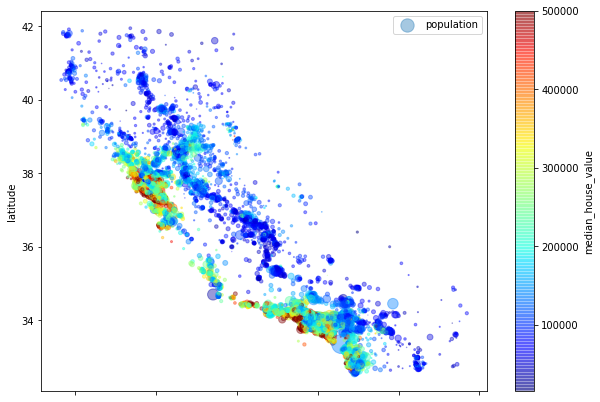

In [15]:
housing.plot(kind = "scatter",x = "longitude",y = "latitude",alpha= 0.4,s= housing["population"]/100, label = "population",
             c = "median_house_value",figsize = (10,7), cmap = plt.get_cmap("jet"),colorbar = True)
plt.legend()

In [16]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021655EFD2E8>,
      dtype=object)

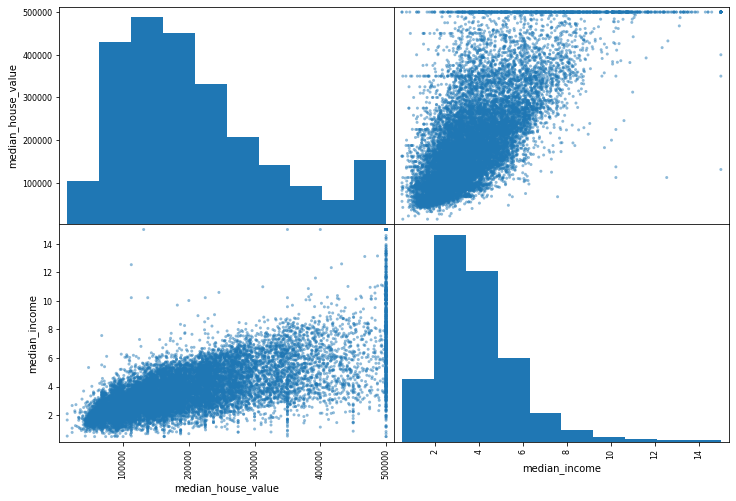

In [17]:
from pandas.plotting import scatter_matrix
att = ["median_house_value","median_income"]
scatter_matrix(housing[att],figsize = (12,8))

In [18]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [19]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')

housing_n = housing.drop("ocean_proximity",axis = 1)


In [21]:
imputer.fit(housing_n)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [22]:
housing_tr = pd.DataFrame(imputer.transform(housing_n),columns = housing_n.columns, index = housing_n.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,3.0


In [23]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [24]:
from sklearn.preprocessing import OneHotEncoder
catenc = OneHotEncoder()
housing_cat_1hot = catenc.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [26]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., 2, 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., 5, 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 2, 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 3, 6.34640522875817, 2.742483660130719],
       [-118.01, 33.82, 31.0, ..., 3, 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 3, 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [27]:
housing_extra_att = pd.DataFrame(housing_extra_attribs,
                                columns = list(housing.columns) +["rooms_per_household","population_per_household"],
                                index = housing.index)
housing_extra_att.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,2,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,5,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,2,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,2,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,3,4.50581,3.04785


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([(
                'imputer',SimpleImputer(strategy = 'median')),
                ('attribs_adder',CombinedAttributesAdder()),
                ('std_scaler',StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_n)

housing_num_tr_df = pd.DataFrame(housing_num_tr,
                                columns = housing_extra_att.columns,
                                index = housing_n.index)
housing_num_tr_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-4.353107e-15,2.284564e-15,-4.701235e-17,7.587062e-17,1.360615e-16,-3.700743e-17,2.078979e-17,-2.102108e-16,1.565285e-16,8.014691e-17,-1.621765e-17,-4.878742e-17
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.384937e+00,-1.449760e+00,-2.199168e+00,-1.223689e+00,-1.294944e+00,-1.269921e+00,-1.317668e+00,-1.772116e+00,-1.902710e+00,-1.650273e+00,-2.075303e-01,-2.704542e+00
25%,-1.111083e+00,-7.949406e-01,-8.472092e-01,-5.516890e-01,-5.793145e-01,-5.698825e-01,-5.803963e-01,-6.870806e-01,-9.544560e-01,-3.822514e-01,-5.741738e-02,-5.914834e-01
50%,5.324379e-01,-6.452675e-01,2.758786e-02,-2.353301e-01,-2.458409e-01,-2.292746e-01,-2.370459e-01,-1.756999e-01,-6.202241e-03,-7.966522e-02,-2.406537e-02,-1.628895e-01
75%,7.822131e-01,9.730728e-01,6.638039e-01,2.423650e-01,2.604547e-01,2.684162e-01,2.793106e-01,4.561338e-01,9.420515e-01,2.358755e-01,1.596812e-02,4.044268e-01
max,2.630550e+00,2.951564e+00,1.856709e+00,1.716114e+01,1.381603e+01,3.071047e+01,1.293803e+01,5.839969e+00,1.890305e+00,5.225419e+01,1.070603e+02,3.975916e+01


In [29]:
housing_n.shape

(16512, 9)

In [32]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_n)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape


(16512, 17)

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class numpytodf(BaseEstimator, TransformerMixin):
    def __init__(self, df):
        self.col = df.columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, df):
        return pd.DataFrame(X,columns = df.columns,index = df.index)
    


In [34]:
ndf = numpytodf(housing_n)

ddf = ndf.transform(housing_prepared[:,0:12],housing_num_tr_df)

In [35]:
ddf.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
17606,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.954456,-0.312055,-0.086499,0.155318
18632,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,1.890305,0.217683,-0.033534,-0.836289
14650,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.954456,-0.465315,-0.092405,0.422200
3230,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.954456,-0.079661,0.089736,-0.196453
3555,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.006202,-0.357834,-0.004194,0.269928


In [36]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

dumm_data = housing.iloc[:5]
dumm_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(dumm_data)

some_predicted_labels = lin_reg.predict(some_data_prepared)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [203682.37379543 326371.39370781 204218.64588245  58685.4770482
 194213.06443039]


In [37]:
print("Labels:", list(dumm_labels))


Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [38]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions,squared = False)
lin_mse

68376.64295459937

In [39]:
#decision tree

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(housing_prepared,housing_labels)

dtree_mse = mean_squared_error(housing_labels,tree_reg.predict(housing_prepared),squared = False)

dtree_mse

0.0

In [40]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg,housing_prepared,housing_labels,
                         scoring = 'neg_mean_squared_error',cv = 10)
tree_rmse_sc = np.sqrt(-scores)
tree_rmse_sc

array([70274.7991723 , 67258.3624668 , 71350.42593227, 68882.91340979,
       70987.99296566, 74177.52037059, 70788.57311306, 70850.53018019,
       76430.62239321, 70212.6471067 ])

In [41]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_sc)

Scores: [70274.7991723  67258.3624668  71350.42593227 68882.91340979
 70987.99296566 74177.52037059 70788.57311306 70850.53018019
 76430.62239321 70212.6471067 ]
Mean: 71121.4387110585
Standard deviation: 2434.3080046605132


In [42]:
lin_scores = cross_val_score(lin_reg,housing_prepared,housing_labels,scoring = 'neg_mean_squared_error',cv = 10)
display_scores(np.sqrt(-lin_scores))

Scores: [66877.52325028 66608.120256   70575.91118868 74179.94799352
 67683.32205678 71103.16843468 64782.65896552 67711.29940352
 71080.40484136 67687.6384546 ]
Mean: 68828.99948449331
Standard deviation: 2662.761570610345


In [43]:
#randomForest

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

rforest_Scores = cross_val_score(forest_reg,housing_prepared,housing_labels,scoring = 'neg_mean_squared_error',cv = 10)

In [44]:
display_scores(np.sqrt(-rforest_Scores))

Scores: [49633.454487   47565.18736589 50034.52343496 52444.25008076
 49463.18392461 53515.10766804 48577.59023701 47678.90315126
 53433.75372939 49947.64462367]
Mean: 50229.359870258486
Standard deviation: 2082.3174179664184


In [45]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

svm_scores = cross_val_score(svm_reg,housing_prepared,housing_labels,scoring = 'neg_mean_squared_error',cv = 10)

display_scores(np.sqrt(-svm_scores))

Scores: [101753.54978461 108380.51380685 106200.32161595 109301.66402916
 106682.29073341 111849.88610827 106534.44353941 110576.7797446
 109867.22584371 107754.78897031]
Mean: 107890.14641762718
Standard deviation: 2699.402075191871


In [46]:
import joblib

def dumpmodel(model,model_name):
    joblib.dump(model,model_name)

In [47]:
dumpmodel(lin_reg,"linear_regression.pkl")
dumpmodel(tree_reg,"Decision_Tree.pkl")
dumpmodel(forest_reg,"Random_Forest.pkl")
dumpmodel(svm_reg,"SVM_regression.pkl")

# FineTune GridSearch

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [49]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64246.880700613496 {'max_features': 2, 'n_estimators': 3}
55869.85367924813 {'max_features': 2, 'n_estimators': 10}
53472.1282558969 {'max_features': 2, 'n_estimators': 30}
61376.36445082522 {'max_features': 4, 'n_estimators': 3}
53846.329115303764 {'max_features': 4, 'n_estimators': 10}
51270.1941502407 {'max_features': 4, 'n_estimators': 30}
59860.61532587693 {'max_features': 6, 'n_estimators': 3}
53114.42460001889 {'max_features': 6, 'n_estimators': 10}
50811.43543872171 {'max_features': 6, 'n_estimators': 30}
59220.31563298743 {'max_features': 8, 'n_estimators': 3}
52884.78697544277 {'max_features': 8, 'n_estimators': 10}
50944.39369116168 {'max_features': 8, 'n_estimators': 30}
62805.52917192821 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54462.1410888642 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61117.32056104296 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53022.992252269294 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

# Randomized Search

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [51]:
rnd_search.best_estimator_
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49931.87687086762 {'max_features': 7, 'n_estimators': 180}
52122.359500383354 {'max_features': 5, 'n_estimators': 15}
51463.975706036916 {'max_features': 3, 'n_estimators': 72}
51381.480933769904 {'max_features': 5, 'n_estimators': 21}
50040.68374785571 {'max_features': 7, 'n_estimators': 122}
51436.83595589131 {'max_features': 3, 'n_estimators': 75}
51286.420458183085 {'max_features': 3, 'n_estimators': 88}
50312.65330988299 {'max_features': 5, 'n_estimators': 100}
50995.48957108733 {'max_features': 3, 'n_estimators': 150}
65455.451908645155 {'max_features': 5, 'n_estimators': 2}


In [52]:
sorted(zip(np.sqrt(-cvres["mean_test_score"]), cvres["params"]),reverse = True)

[(65455.451908645155, {'max_features': 5, 'n_estimators': 2}),
 (52122.359500383354, {'max_features': 5, 'n_estimators': 15}),
 (51463.975706036916, {'max_features': 3, 'n_estimators': 72}),
 (51436.83595589131, {'max_features': 3, 'n_estimators': 75}),
 (51381.480933769904, {'max_features': 5, 'n_estimators': 21}),
 (51286.420458183085, {'max_features': 3, 'n_estimators': 88}),
 (50995.48957108733, {'max_features': 3, 'n_estimators': 150}),
 (50312.65330988299, {'max_features': 5, 'n_estimators': 100}),
 (50040.68374785571, {'max_features': 7, 'n_estimators': 122}),
 (49931.87687086762, {'max_features': 7, 'n_estimators': 180})]

In [53]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.79326113e-02, 6.18280724e-02, 4.33395023e-02, 1.81017027e-02,
       1.83291556e-02, 1.93269892e-02, 1.78369580e-02, 2.41360490e-01,
       1.61976585e-01, 5.35982558e-02, 1.06273526e-01, 6.14045141e-02,
       1.22353255e-02, 1.08821239e-01, 2.76143239e-05, 2.59938294e-03,
       5.00807682e-03])

In [54]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.24136048955382883, 'median_income'),
 (0.16197658459849276, 'income_cat'),
 (0.10882123891274476, 'INLAND'),
 (0.10627352591969835, 'pop_per_hhold'),
 (0.06793261134305181, 'longitude'),
 (0.06182807241916786, 'latitude'),
 (0.061404514078416045, 'bedrooms_per_room'),
 (0.05359825584988402, 'rooms_per_hhold'),
 (0.04333950231438806, 'housing_median_age'),
 (0.019326989179411204, 'population'),
 (0.01832915558242795, 'total_bedrooms'),
 (0.01810170268968371, 'total_rooms'),
 (0.01783695799011688, 'households'),
 (0.012235325483341324, '<1H OCEAN'),
 (0.0050080768169210735, 'NEAR OCEAN'),
 (0.002599382944523225, 'NEAR BAY'),
 (2.7614323902184926e-05, 'ISLAND')]

# Test the system

In [55]:
housing_test_data = strat_test_set.copy()

test_data = housing_test_data.drop("median_house_value",axis = 1)
test_labels = housing_test_data["median_house_value"].copy()

In [56]:
test_data_prepared = full_pipeline.transform(test_data)

In [57]:
final_model = rnd_search.best_estimator_
predictions= final_model.predict(test_data_prepared)

error = mean_squared_error(predictions,test_labels,squared = False)

In [58]:
from scipy import stats

confidence = 0.95
squared_errors = (predictions - test_labels) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45581.5468235 , 49438.53013303])

In [59]:
squared_errors

5241     1.419181e+08
10970    1.016725e+09
20351    4.734204e+07
6568     4.986041e+08
13285    2.776852e+08
             ...     
20519    3.879149e+08
17430    3.919520e+08
4019     5.342033e+08
12107    1.434137e+09
2398     3.033684e+09
Name: median_house_value, Length: 4128, dtype: float64

Exercise 1

In [60]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [61]:
parameters_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'kernel': ["linear"], 'C': [1.0, 0.1, 0.001]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'kernel': ["rbf"], 'C': [1.0, 0.1, 0.001], 'gamma' : [0.001, 0.01, 0.1]}
  ]
grid_search_svm = GridSearchCV(SVR(), parameters_grid, cv = 5,
                              scoring='neg_mean_squared_error',
                               return_train_score=True)
grid_search_svm.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1.0, 0.1, 0.001], 'kernel': ['linear']},
                         {'C': [1.0, 0.1, 0.001], 'gamma': [0.001, 0.01, 0.1],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [62]:
np.sqrt(-grid_search_svm.cv_results_["mean_test_score"])

array([108968.26942819, 117800.31017689, 118911.81826865, 118901.0697722 ,
       118743.74833054, 118556.82411885, 118920.95785282, 118905.45885494,
       118885.04966623, 118923.14318453, 118922.98659057, 118922.78841325])

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.5s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.6s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.7s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   5.6s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  11.8s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  11.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  11.0s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  44.2s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  43.4s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  52.1s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  49.5s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  37.2s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   6.7s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   7.0

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   5.8s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  29.3s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  30.4s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  32.4s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  37.1s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  23.6s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=   

[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  19.5s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  20.6s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   8.8s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   8.9s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   8.7s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   8.8s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   8.7s
[CV] C=399.7268155705

[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   5.5s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   5.6s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   5.5s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   8.7s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   8.7s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   8.8s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   8.7s
[CV] C=2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 2876.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002165679FC88>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002165679F780>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

Transformer for most important attribute

In [64]:
model = RandomForestRegressor(random_state=42, max_features= 7, n_estimators =  180)
model.fit(housing_prepared, housing_labels)

mean_squared_error(model.predict(test_data_prepared),test_labels,squared = False)



47549.16230880196

In [65]:
feature_import = model.feature_importances_

feature_import
sorted(zip(feature_import, attributes), reverse=True)

feature_import_df = pd.DataFrame(sorted(zip(feature_import, attributes), reverse=True),columns = ["Importance","Feature_name"])
feature_import_df

,Importance,Feature_name
0,0.274110,median_income
1,0.143647,income_cat
2,0.135963,INLAND
3,0.107115,pop_per_hhold
4,0.065655,longitude
5,0.059962,latitude
6,0.049708,bedrooms_per_room
7,0.044003,housing_median_age
8,0.037776,rooms_per_hhold
9,0.017088,population


In [66]:
important_f = list(feature_import_df["Feature_name"].head(7))
important_f

['median_income',
 'income_cat',
 'INLAND',
 'pop_per_hhold',
 'longitude',
 'latitude',
 'bedrooms_per_room']

In [67]:
x = np.array([30,35, 40, 20, 10,90,56])
y= x[np.argpartition(x, 2)]
y

array([10, 20, 30, 35, 40, 90, 56])

In [68]:
housing_prepared_df = pd.DataFrame(housing_prepared,columns = attributes)
model.fit(housing_prepared_df[important_f],housing_labels)



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=180, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [69]:
test_data_prepared_df = pd.DataFrame(test_data_prepared,columns = attributes)
mean_squared_error(model.predict(test_data_prepared_df[important_f]),test_labels, squared = False)


48220.7007587696

In [70]:
from scipy import stats

confidence = 0.95
squared_errors = (model.predict(test_data_prepared_df[important_f]) - test_labels) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46171.2606797 , 50186.51861387])

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [72]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_import, 5))
])

In [73]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [74]:
k = 5
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_import, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

In [75]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}